# Forest Land Area (percentage of total land area)
In this notebook we will predict forest land area based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure.

Data cleaning: 
- Cleaning and assessing forest data 
- Combining forest data with Predictor data
- Imputing variables and removing NaN countries 
- Lagging and log transform the forest area variable 
- Adding the size rank variable 

Data exploration:
- Exploring correlations with the predictor data 
- Checking for outliers 

Data splitting 
- Splitting the combined dataset in training, validation and testing data
- Checking whether the training split data is a representative sample and not confined to one area of the world.

Data modelling, linear regression:

- Linear regression base line models per country
    - Fitting baseline model (median model)
    - Fitting simple model (demographic variables)
    
- Linear regression theory driven models per country (social)
    - Social theory driven model 
    - Full social model 

- Linear regression theory driven models per country (governance)
    - Governance theory drive model 
    - Full governance model

Data modelling, random forest:

- Mixed effect random forest social model 
- Mixed effect random forest governance model 
- Mixed effect all predictor model


# Cleaning and combining data 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [5]:
#Read file 
df = pd.read_csv('Data/forest.xlsx')
print(df)

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 15-16: invalid continuation byte

Removing: 
- columns with 0 counts (keeping from 1990-2021)
- non-iso countries

In [3]:
#Remove columns with 0 counts
summary = df.describe()

count_row = summary.loc['count']

columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

df_90 = df.drop(columns=columns_with_zero_count)

display(df_90)

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,Forest area (sq. km),AG.LND.FRST.K2,4.2,4.200,4.200,4.200,4.200,4.20,...,4.20,4.20,4.20,4.2,4.200,4.2,4.20,4.2,4.2,4.200
1,Africa Eastern and Southern,AFE,Forest area (sq. km),AG.LND.FRST.K2,5279295.5,5257255.464,5235215.428,5213175.392,5191135.356,5169095.32,...,4734211.36,4703021.74,4671832.12,4640642.5,4607876.100,4575901.2,4544314.78,4511676.2,4479395.0,4446875.546
2,Afghanistan,AFG,Forest area (sq. km),AG.LND.FRST.K2,12084.4,12084.400,12084.400,12084.400,12084.400,12084.40,...,12084.40,12084.40,12084.40,12084.4,12084.400,12084.4,12084.40,12084.4,12084.4,12084.400
3,Africa Western and Central,AFW,Forest area (sq. km),AG.LND.FRST.K2,2060349.0,2049660.284,2038971.568,2028282.852,2017594.136,2006905.42,...,1854212.96,1846256.64,1838300.32,1830344.0,1822960.779,1815608.1,1807898.60,1800220.1,1792580.7,1784915.233
4,Angola,AGO,Forest area (sq. km),AG.LND.FRST.K2,792627.8,791073.630,789519.460,787965.290,786411.120,784856.95,...,710478.76,704928.14,699377.52,693826.9,688276.200,682725.7,677175.10,671624.4,666073.8,660523.133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Forest area (sq. km),AG.LND.FRST.K2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,"Yemen, Rep.",YEM,Forest area (sq. km),AG.LND.FRST.K2,5490.0,5490.000,5490.000,5490.000,5490.000,5490.00,...,5490.00,5490.00,5490.00,5490.0,5490.000,5490.0,5490.00,5490.0,5490.0,5490.000
263,South Africa,ZAF,Forest area (sq. km),AG.LND.FRST.K2,181420.9,181056.900,180692.900,180328.900,179964.900,179600.90,...,173412.90,173048.90,172684.90,172320.9,171956.900,171592.9,171228.90,170864.9,170500.9,170136.900
264,Zambia,ZMB,Forest area (sq. km),AG.LND.FRST.K2,474120.0,473762.000,473404.000,473046.000,472688.000,472330.00,...,463196.40,461314.60,459432.80,457551.0,455668.000,453786.7,451904.60,450022.4,448140.3,446258.133


In [4]:
#Removing non countries 
ISO_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']

df_iso = df_90[df_90['Country Code'].isin(ISO_list)]

print(df_iso)

     Country Name Country Code        Indicator Name  Indicator Code  \
0           Aruba          ABW  Forest area (sq. km)  AG.LND.FRST.K2   
2     Afghanistan          AFG  Forest area (sq. km)  AG.LND.FRST.K2   
4          Angola          AGO  Forest area (sq. km)  AG.LND.FRST.K2   
5         Albania          ALB  Forest area (sq. km)  AG.LND.FRST.K2   
6         Andorra          AND  Forest area (sq. km)  AG.LND.FRST.K2   
..            ...          ...                   ...             ...   
260         Samoa          WSM  Forest area (sq. km)  AG.LND.FRST.K2   
262   Yemen, Rep.          YEM  Forest area (sq. km)  AG.LND.FRST.K2   
263  South Africa          ZAF  Forest area (sq. km)  AG.LND.FRST.K2   
264        Zambia          ZMB  Forest area (sq. km)  AG.LND.FRST.K2   
265      Zimbabwe          ZWE  Forest area (sq. km)  AG.LND.FRST.K2   

         1990       1991       1992       1993       1994       1995  ...  \
0         4.2       4.20       4.20       4.20       4.20 

Make the wide df long instead.

In [5]:
melted_df = pd.melt(df_iso, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='forest_area')
melted_df['Year'] = melted_df['Year'].astype(float)
print(melted_df)

     Country Code  Country Name        Indicator Name  Indicator Code    Year  \
0             ABW         Aruba  Forest area (sq. km)  AG.LND.FRST.K2  1990.0   
1             AFG   Afghanistan  Forest area (sq. km)  AG.LND.FRST.K2  1990.0   
2             AGO        Angola  Forest area (sq. km)  AG.LND.FRST.K2  1990.0   
3             ALB       Albania  Forest area (sq. km)  AG.LND.FRST.K2  1990.0   
4             AND       Andorra  Forest area (sq. km)  AG.LND.FRST.K2  1990.0   
...           ...           ...                   ...             ...     ...   
6875          WSM         Samoa  Forest area (sq. km)  AG.LND.FRST.K2  2021.0   
6876          YEM   Yemen, Rep.  Forest area (sq. km)  AG.LND.FRST.K2  2021.0   
6877          ZAF  South Africa  Forest area (sq. km)  AG.LND.FRST.K2  2021.0   
6878          ZMB        Zambia  Forest area (sq. km)  AG.LND.FRST.K2  2021.0   
6879          ZWE      Zimbabwe  Forest area (sq. km)  AG.LND.FRST.K2  2021.0   

      forest_area  
0      

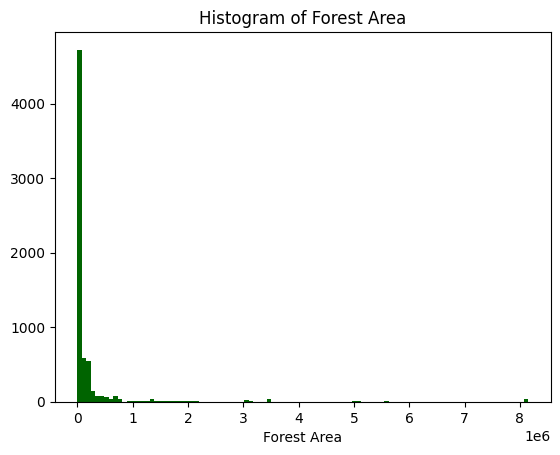

In [11]:
plt.hist(melted_df['forest_area'], bins=100, color='darkgreen')
#sns.histplot(data=melted_df, x='forest_area', binwidth=0.1)
plt.title('Histogram of Forest Area')
plt.xlabel('Forest Area')
plt.show()


We can see that we have countries that have 0 percent, which probably just is an indicator of not being able to record forest areas. 

In [12]:
#Making a list for all countries that have exactly 0.0 sqkm forest and removing those. 

zero_countries = melted_df.groupby('Country Code')['forest_area'].sum()

zero_countries = zero_countries[zero_countries == 0.0].index.tolist()

forest = melted_df[~melted_df['Country Code'].isin(zero_countries)]


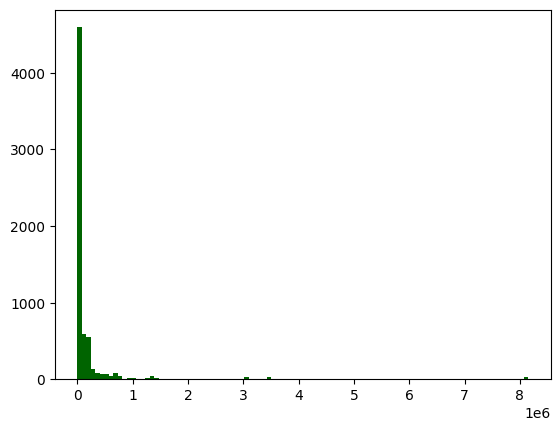

In [13]:
plt.hist(forest['forest_area'], bins=100, color='darkgreen')
#sns.histplot(data=forest, x='forest_area', binwidth=0.1)
plt.show()

We still do have a lot around 0, but no values of 0.0 anymore. Which means that the rest must be correct numbers and na's. 

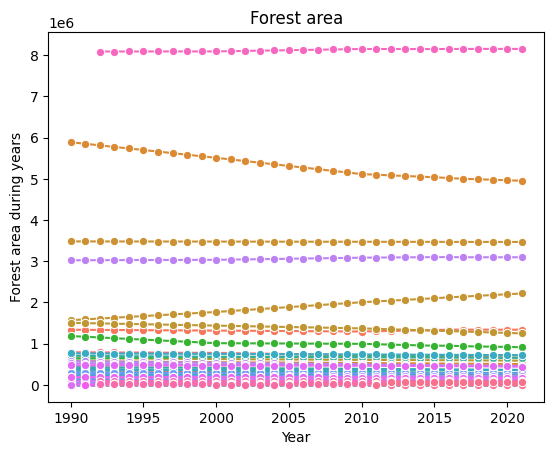

In [33]:
sns.lineplot(data=forest, x='Year', y='forest_area', hue='Country Code', marker='o', legend=False)

# Add title and labels
plt.title('Forest area')
plt.xlabel('Year')
plt.ylabel('Forest area during years')


# Show the plot
plt.show()

Log transforming to get more normal distributed data.

In [18]:
forest['log_forest'] = np.log(forest['forest_area'])

display(forest)

C:\Users\mlj\AppData\Local\Temp\ipykernel_26652\290108596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forest['log_forest'] = np.log(forest['forest_area'])


,Country Code,Country Name,Indicator Name,Indicator Code,Year,forest_area,log_forest
0,ABW,Aruba,Forest area (sq. km),AG.LND.FRST.K2,1990.0,4.200,1.435085
1,AFG,Afghanistan,Forest area (sq. km),AG.LND.FRST.K2,1990.0,12084.400,9.399671
2,AGO,Angola,Forest area (sq. km),AG.LND.FRST.K2,1990.0,792627.800,13.583109
3,ALB,Albania,Forest area (sq. km),AG.LND.FRST.K2,1990.0,7888.000,8.973098
4,AND,Andorra,Forest area (sq. km),AG.LND.FRST.K2,1990.0,160.000,5.075174
...,...,...,...,...,...,...,...
6875,WSM,Samoa,Forest area (sq. km),AG.LND.FRST.K2,2021.0,1611.900,7.385169
6876,YEM,"Yemen, Rep.",Forest area (sq. km),AG.LND.FRST.K2,2021.0,5490.000,8.610684
6877,ZAF,South Africa,Forest area (sq. km),AG.LND.FRST.K2,2021.0,170136.900,12.044359
6878,ZMB,Zambia,Forest area (sq. km),AG.LND.FRST.K2,2021.0,446258.133,13.008653


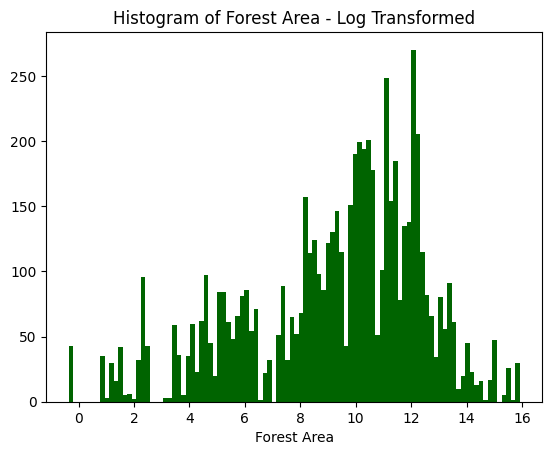

In [20]:
plt.hist(forest['log_forest'], bins=100, color='darkgreen')
#sns.histplot(data=forest, x='forest_area', binwidth=0.1)
plt.title('Histogram of Forest Area - Log Transformed')
plt.xlabel('Forest Area')
plt.show()
plt.show()

### Combine with predictor data 

In [21]:
#Read predictor file 

pred = pd.read_excel('git_data/predictor_data.xlsx')

print(pred)

                           Country Name Country Code  Year  Population, total  \
0                                 Aruba          ABW  1960            54608.0   
1           Africa Eastern and Southern          AFE  1960        130692579.0   
2                           Afghanistan          AFG  1960          8622466.0   
3            Africa Western and Central          AFW  1960         97256290.0   
4                                Angola          AGO  1960          5357195.0   
...                                 ...          ...   ...                ...   
17769                         Swaziland          SWZ  2021                NaN   
17770      Tanzania, United Republic of          TZA  2021                NaN   
17771                            Turkey          TUR  2021                NaN   
17772  Venezuela, Bolivarian Republic o          VEN  2021                NaN   
17773                             Yemen          YEM  2021                NaN   

       Land area (sq. km)  

In [22]:
#Renaming so no double names
forest = forest.rename(columns={'Country Name':'Country'})

#combining forest and pred data
forest_full = pd.merge(forest, pred, on = ['Year', 'Country Code'], how = 'inner')

#removing excess country column
forest_full = forest_full.drop(columns=['Country'])


Removing countries with all NaN in one column or half of the variables in the columns is NaN.

In [23]:
# Initialize an empty list to store the countries with all NaNs in at least one predictor column
countries_with_all_nans = []
# Initialize an empty list to store the removed countries
removed_countries = []

# Filter the dataset to only include rows where 'Year' is between 1996 and 2020
forest_full_filtered = forest_full[(forest_full['Year'] >= 1996) & (forest_full['Year'] <= 2020)]

#forest_full_filtered.info()

# Identify countries with NaN in forest_area (total of 8 countries)
countries_with_nan = forest_full_filtered[
    (forest_full_filtered['forest_area'].isna())
]['Country Code'].unique()

# Filter out these countries from the dataset
forest_full_filtered = forest_full_filtered[~forest_full_filtered['Country Code'].isin(countries_with_nan)]

#Checkin how many countries were removed
print(len(forest_full_filtered['Country Code'].unique()))
print(len(forest_full['Country Code'].unique()))


201
209


In [24]:
# Define the non-predictor columns
non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'forest_area', 'Education', 'Innovation', 'Social Inequality'
]

# Determine the number of predictors by excluding non-predictor columns
predictor_columns = forest_full_filtered.columns.difference(non_predictor_columns)

# Calculate the threshold (more than half of the predictors)
threshold = len(predictor_columns) / 2

# Filter out rows where more than half of the predictors have NaN values
forest_full_filtered = forest_full_filtered[forest_full_filtered[predictor_columns].isnull().sum(axis=1) <= threshold]

#Checking how many countries were removed
print(len(forest_full_filtered['Country Code'].unique()))
print(len(forest_full['Country Code'].unique()))

189
209


In [25]:
# Loop through each predictor column
for predictor_column in predictor_columns:
    # Group the data by country and check if all values in the current predictor column are NaN
    countries_with_nans = forest_full_filtered.groupby('Country Code')[predictor_column].apply(lambda x: x.isnull().all())
    
    # Add countries with all NaNs in the current predictor column to the list
    countries_with_all_nans.extend(countries_with_nans[countries_with_nans].index.tolist())

# Remove duplicate countries from the list
countries_with_all_nans = list(set(countries_with_all_nans))

# Add removed countries to the list
removed_countries.extend(countries_with_all_nans)

# Remove countries with all NaNs in at least one predictor column from the dataset
forest_full_filtered = forest_full_filtered[~forest_full_filtered['Country Code'].isin(countries_with_all_nans)]

# Display the removed countries
print("Countries removed using country code:", removed_countries)

#Checking how many countries were removed
print(len(forest_full_filtered['Country Code'].unique()))
print(len(forest_full['Country Code'].unique()))

Countries removed using country code: ['BHS', 'BMU', 'KNA', 'PRI', 'PRK', 'SWZ', 'LBY', 'CYM', 'BOL', 'VNM', 'GMB', 'CPV', 'VCT', 'TUR', 'LIE', 'LAO', 'EGY', 'FSM', 'CZE', 'VEN', 'STP', 'VIR', 'SVK', 'MKD', 'ABW', 'GRL', 'MDA', 'YEM', 'TZA', 'KOR', 'CIV', 'COG', 'KGZ', 'IRN', 'LCA', 'ASM', 'GUM']
152
209


In [26]:
print(len(forest_full_filtered['Country Code'].unique()))
print(forest_full_filtered.isna().sum())

152
Country Code             0
Indicator Name           0
Indicator Code           0
Year                     0
forest_area              0
log_forest               0
Country Name             0
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                  24
WGI GE                  56
WGI RQ                  56
WGI RL                   1
WGI CC                  46
Education             1168
Innovation            1491
Social Inequality     2064
ICT                    760
Health                   0
dtype: int64


We end up with 152 countries, and the relevant predictors mostly have fewer than 60 NaN. Then we impute the data for each of the countries where at least half of the observations are not NaN.

In [27]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separate the data by country
grouped_data = forest_full_filtered.groupby('Country Code')

non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'forest_area', 'Education', 'Innovation', 'Social Inequality', 'log_forest'
]

# Initialize an empty list to store imputed data frames
imputed_data_frames = []

# Iterate over each group and perform imputation
for country_code, group in grouped_data:
    # Drop non-predictor columns for imputation
    data_for_imputation = group.drop(columns=non_predictor_columns)

    # Initialize the IterativeImputer
    imputer = IterativeImputer(random_state=42)

    # Fit and transform the imputer on the data
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Print shapes for debugging
    print("Shape of data_for_imputation:", data_for_imputation.shape)
    print("Shape of imputed_data:", imputed_data.shape)

    # Convert the imputed data back to DataFrame
    imputed_group = pd.DataFrame(imputed_data, columns=data_for_imputation.columns)

    # Reset index of the imputed group
    imputed_group.reset_index(drop=True, inplace=True)

    # Merge back the non-predictor columns with the imputed data
    imputed_group = pd.concat([group[non_predictor_columns].reset_index(drop=True), imputed_group], axis=1)

    # Append the imputed group to the list
    imputed_data_frames.append(imputed_group)

# Combine all the imputed data frames into one
forest_full_imputed = pd.concat(imputed_data_frames, ignore_index=True)

# Display the imputed dataset
#display(forest_full_imputed)

Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape 

In [28]:
forest_full_imputed.isna().sum()

Country Code             0
Country Name             0
Indicator Name           0
Indicator Code           0
Year                     0
forest_area              0
Education             1168
Innovation            1491
Social Inequality     2064
log_forest               0
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                   0
WGI GE                   0
WGI RQ                   0
WGI RL                   0
WGI CC                   0
ICT                      0
Health                   0
dtype: int64

In [29]:
forest_full_imputed = forest_full_imputed.drop(columns=['Indicator Name', 'Indicator Code', 'Education', 'Innovation', 'Social Inequality'])
forest_full_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344 entries, 0 to 3343
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        3344 non-null   object 
 1   Country Name        3344 non-null   object 
 2   Year                3344 non-null   float64
 3   forest_area         3344 non-null   float64
 4   log_forest          3344 non-null   float64
 5   Population, total   3344 non-null   float64
 6   Land area (sq. km)  3344 non-null   float64
 7   WGI VA              3344 non-null   float64
 8   WGI PS              3344 non-null   float64
 9   WGI GE              3344 non-null   float64
 10  WGI RQ              3344 non-null   float64
 11  WGI RL              3344 non-null   float64
 12  WGI CC              3344 non-null   float64
 13  ICT                 3344 non-null   float64
 14  Health              3344 non-null   float64
dtypes: float64(13), object(2)
memory usage: 392.0+ KB


Delaying the forest area variable.

In [30]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'lagged_ghg' and initializing with NaN
forest_full_imputed['lagged_forest'] = pd.NA

#Iterating over each row
for i in range(len(forest_full_imputed)):
    country = forest_full_imputed.loc[i, 'Country Code']
    year = forest_full_imputed.loc[i, 'Year']

    correct_year = year + lag_years
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = forest_full_imputed[(forest_full_imputed['Country Code'] == country) & (forest_full_imputed['Year'] == correct_year)]
    
    #print(lagged_row['ghg'])
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        forest_full_imputed.loc[i, 'lagged_forest'] = lagged_row['log_forest'].values[0]

#Display the new dataframe 
display(forest_full_imputed)

,Country Code,Country Name,Year,forest_area,log_forest,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_forest
0,AFG,Afghanistan,1996.0,12084.4,9.399671,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,9.399671
1,AFG,Afghanistan,1998.0,12084.4,9.399671,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,9.399671
2,AFG,Afghanistan,2000.0,12084.4,9.399671,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,9.399671
3,AFG,Afghanistan,2002.0,12084.4,9.399671,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,9.399671
4,AFG,Afghanistan,2003.0,12084.4,9.399671,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,9.399671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,176288.6,12.079878,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298,12.069369
3340,ZWE,Zimbabwe,2017.0,175827.9,12.077261,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267,<NA>
3341,ZWE,Zimbabwe,2018.0,175367.2,12.074637,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913,<NA>
3342,ZWE,Zimbabwe,2019.0,174906.5,12.072007,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938,<NA>


In [32]:
#Checking if the lagged is correct 
print(forest_full_imputed[(forest_full_imputed['Country Code'] == 'ZWE') & (forest_full_imputed['Year'] == 2000.0)]['log_forest'])

print(forest_full_imputed[(forest_full_imputed['Country Code'] == 'ZWE') & (forest_full_imputed['Year'] == 1996.0)]['lagged_forest'])

3324    12.12084
Name: log_forest, dtype: float64
3322    12.12084
Name: lagged_forest, dtype: object


In [33]:
forest_full_imputed['lagged_forest'] = pd.to_numeric(forest_full_imputed['lagged_forest'])
forest_full_imputed = forest_full_imputed.rename(columns={'Land area (sq. km)':'land_area'})
forest_full_imputed = forest_full_imputed.rename(columns={'Population, total':'population'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI VA':'WGI_va'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI GE':'WGI_ge'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI RL':'WGI_rl'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI RQ':'WGI_rq'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI PS':'WGI_ps'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI CC':'WGI_cc'})
forest_full_imputed =forest_full_imputed.dropna()

display(forest_full_imputed)

,Country Code,Country Name,Year,forest_area,log_forest,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest
0,AFG,Afghanistan,1996.0,12084.4,9.399671,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,9.399671
1,AFG,Afghanistan,1998.0,12084.4,9.399671,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,9.399671
2,AFG,Afghanistan,2000.0,12084.4,9.399671,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,9.399671
3,AFG,Afghanistan,2002.0,12084.4,9.399671,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,9.399671
4,AFG,Afghanistan,2003.0,12084.4,9.399671,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,9.399671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,ZWE,Zimbabwe,2012.0,178131.4,12.090277,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,12.079878
3336,ZWE,Zimbabwe,2013.0,177670.7,12.087687,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,12.077261
3337,ZWE,Zimbabwe,2014.0,177210.0,12.085091,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,12.074637
3338,ZWE,Zimbabwe,2015.0,176749.3,12.082488,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,12.072007


In [34]:
print(forest_full_imputed.isna().sum())
print(len(forest_full_imputed['Country Code'].unique()))

Country Code     0
Country Name     0
Year             0
forest_area      0
log_forest       0
population       0
land_area        0
WGI_va           0
WGI_ps           0
WGI_ge           0
WGI_rq           0
WGI_rl           0
WGI_cc           0
ICT              0
Health           0
lagged_forest    0
dtype: int64
152


In [35]:
forest = forest_full_imputed

forest_size = forest[['Country Code', 'land_area', 'Year']]

forest_group = forest_size.groupby('Country Code')['land_area'].mean()


forest_size_mean = forest_group.reset_index(name='mean_land_area')
display(forest_size_mean)

#Sort forest by population in ascending order
forest_size_mean = forest_size_mean.sort_values(by='mean_land_area', ascending=True).reset_index(drop=True)

forest_size_mean['Size_rank'] = forest_size_mean.index + 1

display(forest_size_mean)

,Country Code,mean_land_area
0,AFG,652230.0
1,AGO,1246700.0
2,ALB,27400.0
3,ARE,71020.0
4,ARG,2736690.0
...,...,...
147,VUT,12190.0
148,WSM,2830.0
149,ZAF,1213090.0
150,ZMB,743390.0


,Country Code,mean_land_area,Size_rank
0,TUV,3.000000e+01,1
1,SMR,6.000000e+01,2
2,MHL,1.800000e+02,3
3,MDV,3.000000e+02,4
4,MLT,3.200000e+02,5
...,...,...,...
147,BRA,8.358140e+06,148
148,CAN,8.965590e+06,149
149,USA,9.154341e+06,150
150,CHN,9.388214e+06,151


In [36]:
#Merging the size rank into ghg again
forest = forest.merge(forest_size_mean[['Country Code', 'Size_rank']], on='Country Code')
display(forest)

,Country Code,Country Name,Year,forest_area,log_forest,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest,Size_rank
0,AFG,Afghanistan,1996.0,12084.4,9.399671,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,9.399671,121
1,AFG,Afghanistan,1998.0,12084.4,9.399671,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,9.399671,121
2,AFG,Afghanistan,2000.0,12084.4,9.399671,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,9.399671,121
3,AFG,Afghanistan,2002.0,12084.4,9.399671,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,9.399671,121
4,AFG,Afghanistan,2003.0,12084.4,9.399671,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,9.399671,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ZWE,Zimbabwe,2012.0,178131.4,12.090277,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,12.079878,103
2732,ZWE,Zimbabwe,2013.0,177670.7,12.087687,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,12.077261,103
2733,ZWE,Zimbabwe,2014.0,177210.0,12.085091,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,12.074637,103
2734,ZWE,Zimbabwe,2015.0,176749.3,12.082488,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,12.072007,103


In [37]:
forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Code   2736 non-null   object 
 1   Country Name   2736 non-null   object 
 2   Year           2736 non-null   float64
 3   forest_area    2736 non-null   float64
 4   log_forest     2736 non-null   float64
 5   population     2736 non-null   float64
 6   land_area      2736 non-null   float64
 7   WGI_va         2736 non-null   float64
 8   WGI_ps         2736 non-null   float64
 9   WGI_ge         2736 non-null   float64
 10  WGI_rq         2736 non-null   float64
 11  WGI_rl         2736 non-null   float64
 12  WGI_cc         2736 non-null   float64
 13  ICT            2736 non-null   float64
 14  Health         2736 non-null   float64
 15  lagged_forest  2736 non-null   float64
 16  Size_rank      2736 non-null   int64  
dtypes: float64(14), int64(1), object(2)
memory usage: 36

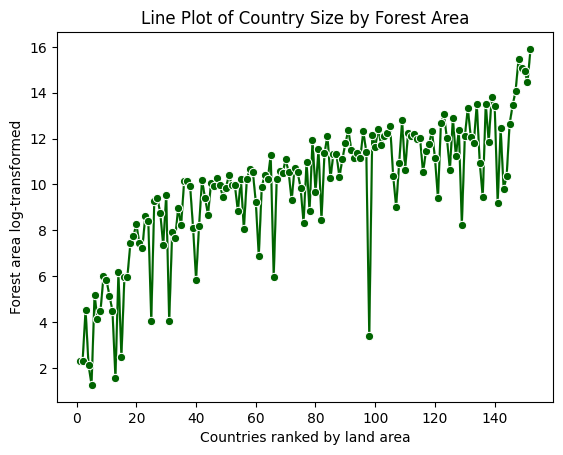

In [39]:
sns.lineplot(x='Size_rank', y='log_forest', data = forest,marker='o', color='darkgreen')
plt.title('Line Plot of Country Size by Forest Area')
plt.xlabel('Countries ranked by land area')
plt.ylabel('Forest area log-transformed')
plt.show()

Consider removing Oman. 

### Save combined clean data 

In [40]:
forest.to_csv('git_data/forest-modelling.csv', index=False)

# Data exploration

In [70]:
colors=sns.color_palette('Paired'); my_palette={'train': colors[1], 'test': colors[0], 'val':colors[2]}

In [71]:
#Load in cleaned data 
forest = pd.read_csv('git_data/forest-modelling.csv')

forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Code   2736 non-null   object 
 1   Country Name   2736 non-null   object 
 2   Year           2736 non-null   float64
 3   forest_area    2736 non-null   float64
 4   log_forest     2736 non-null   float64
 5   population     2736 non-null   float64
 6   land_area      2736 non-null   float64
 7   WGI_va         2736 non-null   float64
 8   WGI_ps         2736 non-null   float64
 9   WGI_ge         2736 non-null   float64
 10  WGI_rq         2736 non-null   float64
 11  WGI_rl         2736 non-null   float64
 12  WGI_cc         2736 non-null   float64
 13  ICT            2736 non-null   float64
 14  Health         2736 non-null   float64
 15  lagged_forest  2736 non-null   float64
 16  Size_rank      2736 non-null   int64  
dtypes: float64(14), int64(1), object(2)
memory usage: 36

### Plotting and data exploration

Forest area per country over years.

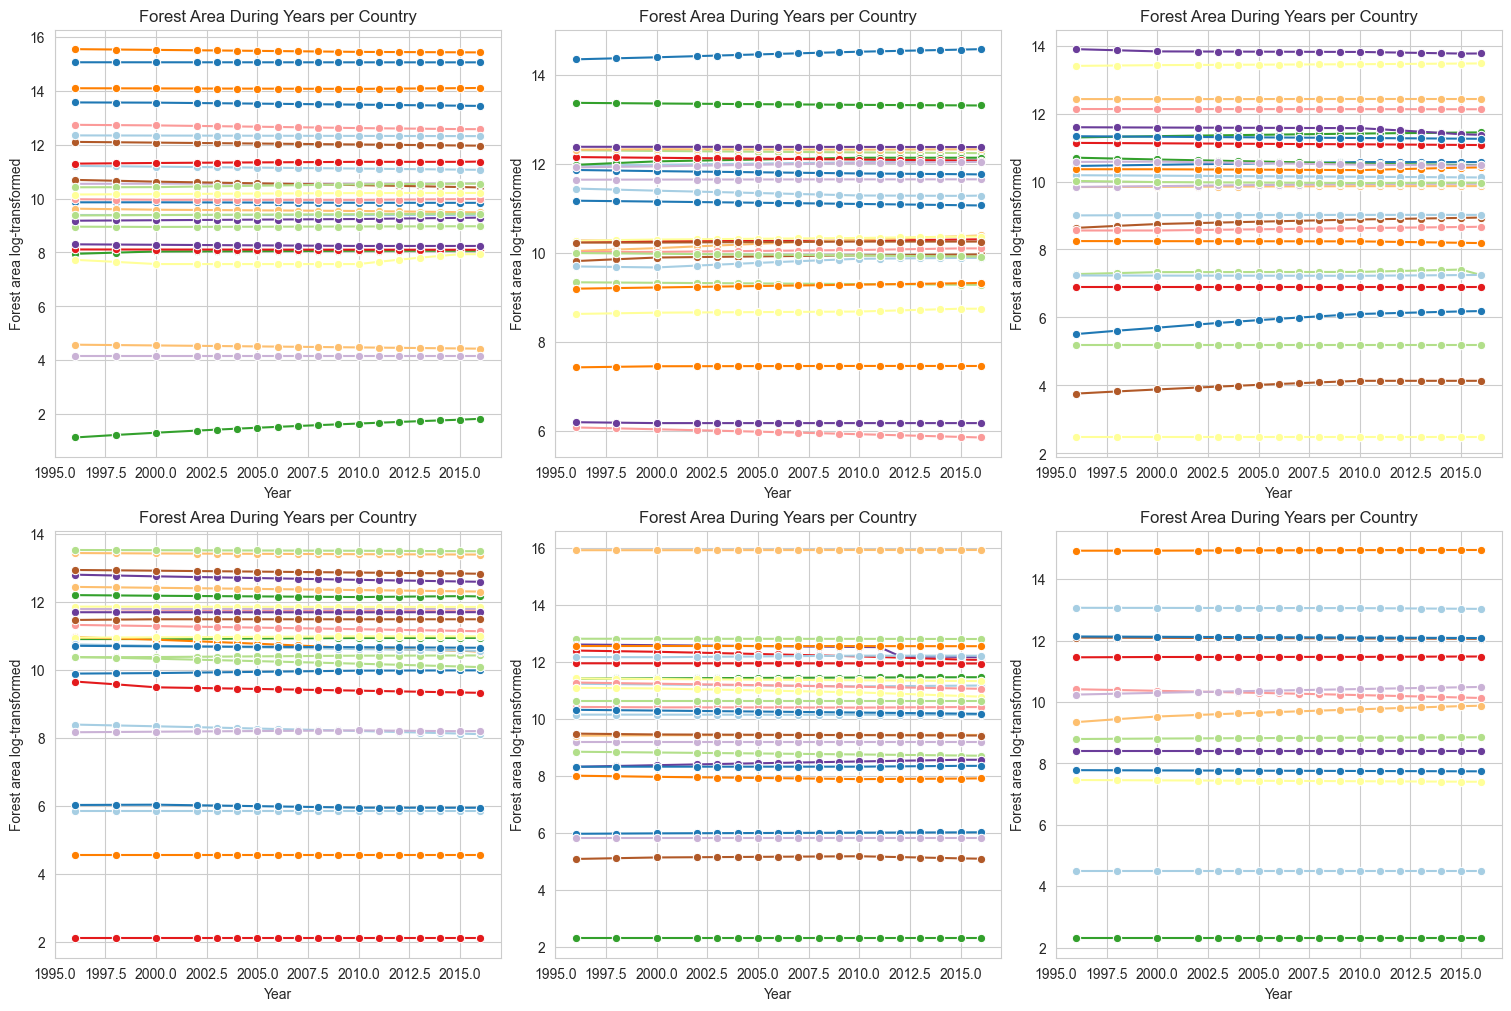

In [96]:
#Dividing by contries
countries = forest['Country Code'].unique()
countries_per_fig = 27
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = forest[forest['Country Code'].isin(group)]
    sns.lineplot(x='Year', y='log_forest', data= data, hue = 'Country Code', marker='o', legend=False, ax=ax, palette='Paired')
    #ax.set_title(f'Boxplot of GHG values by Country - Group {i + 1}')
    ax.set_title('Forest Area During Years per Country')
    #ax.set_xlabel('Country Code')
    ax.set_ylabel('Forest area log-transformed')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.show()

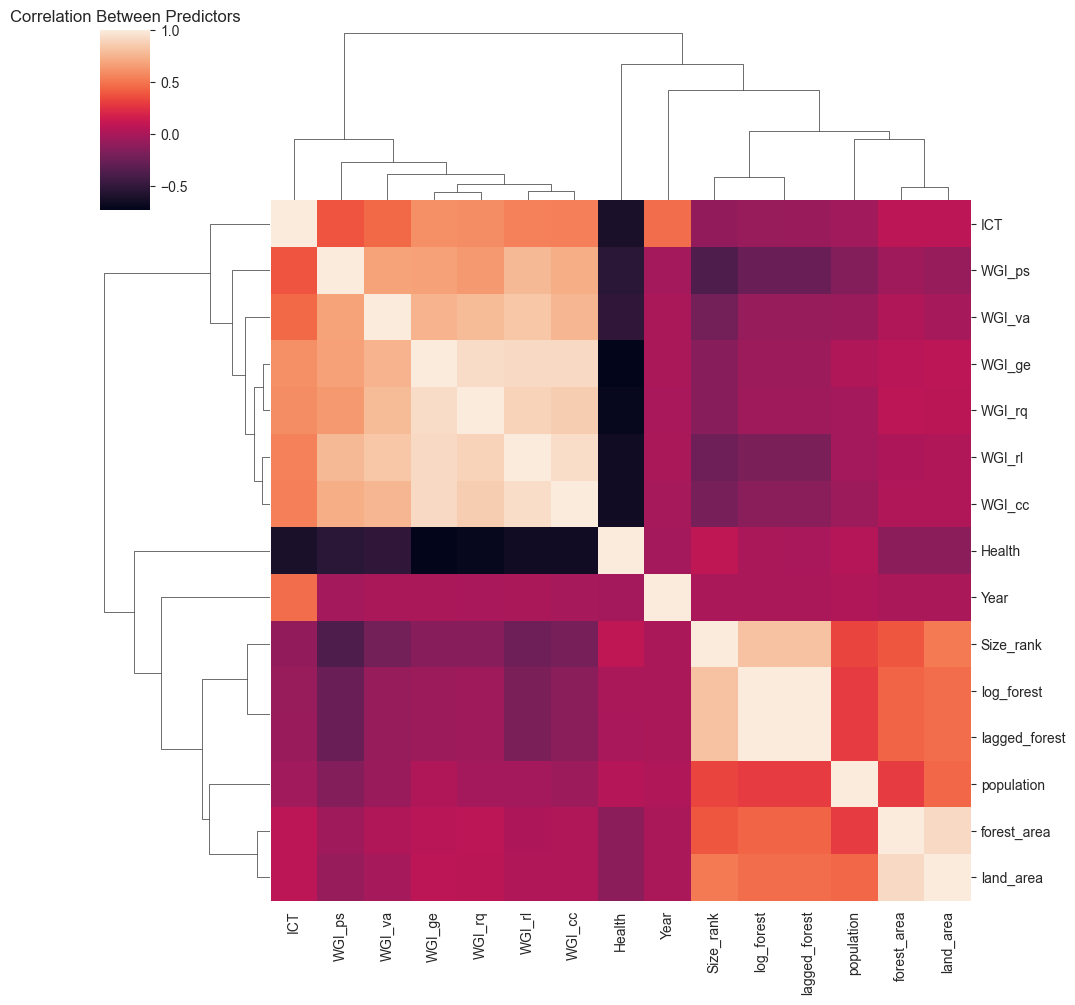

In [98]:
forest_num = forest[forest.select_dtypes(exclude=['object']).columns]

sns.clustermap(forest_num.corr())
plt.title('Correlation Between Predictors')
plt.show()

### Checking for/Reducing outliers 

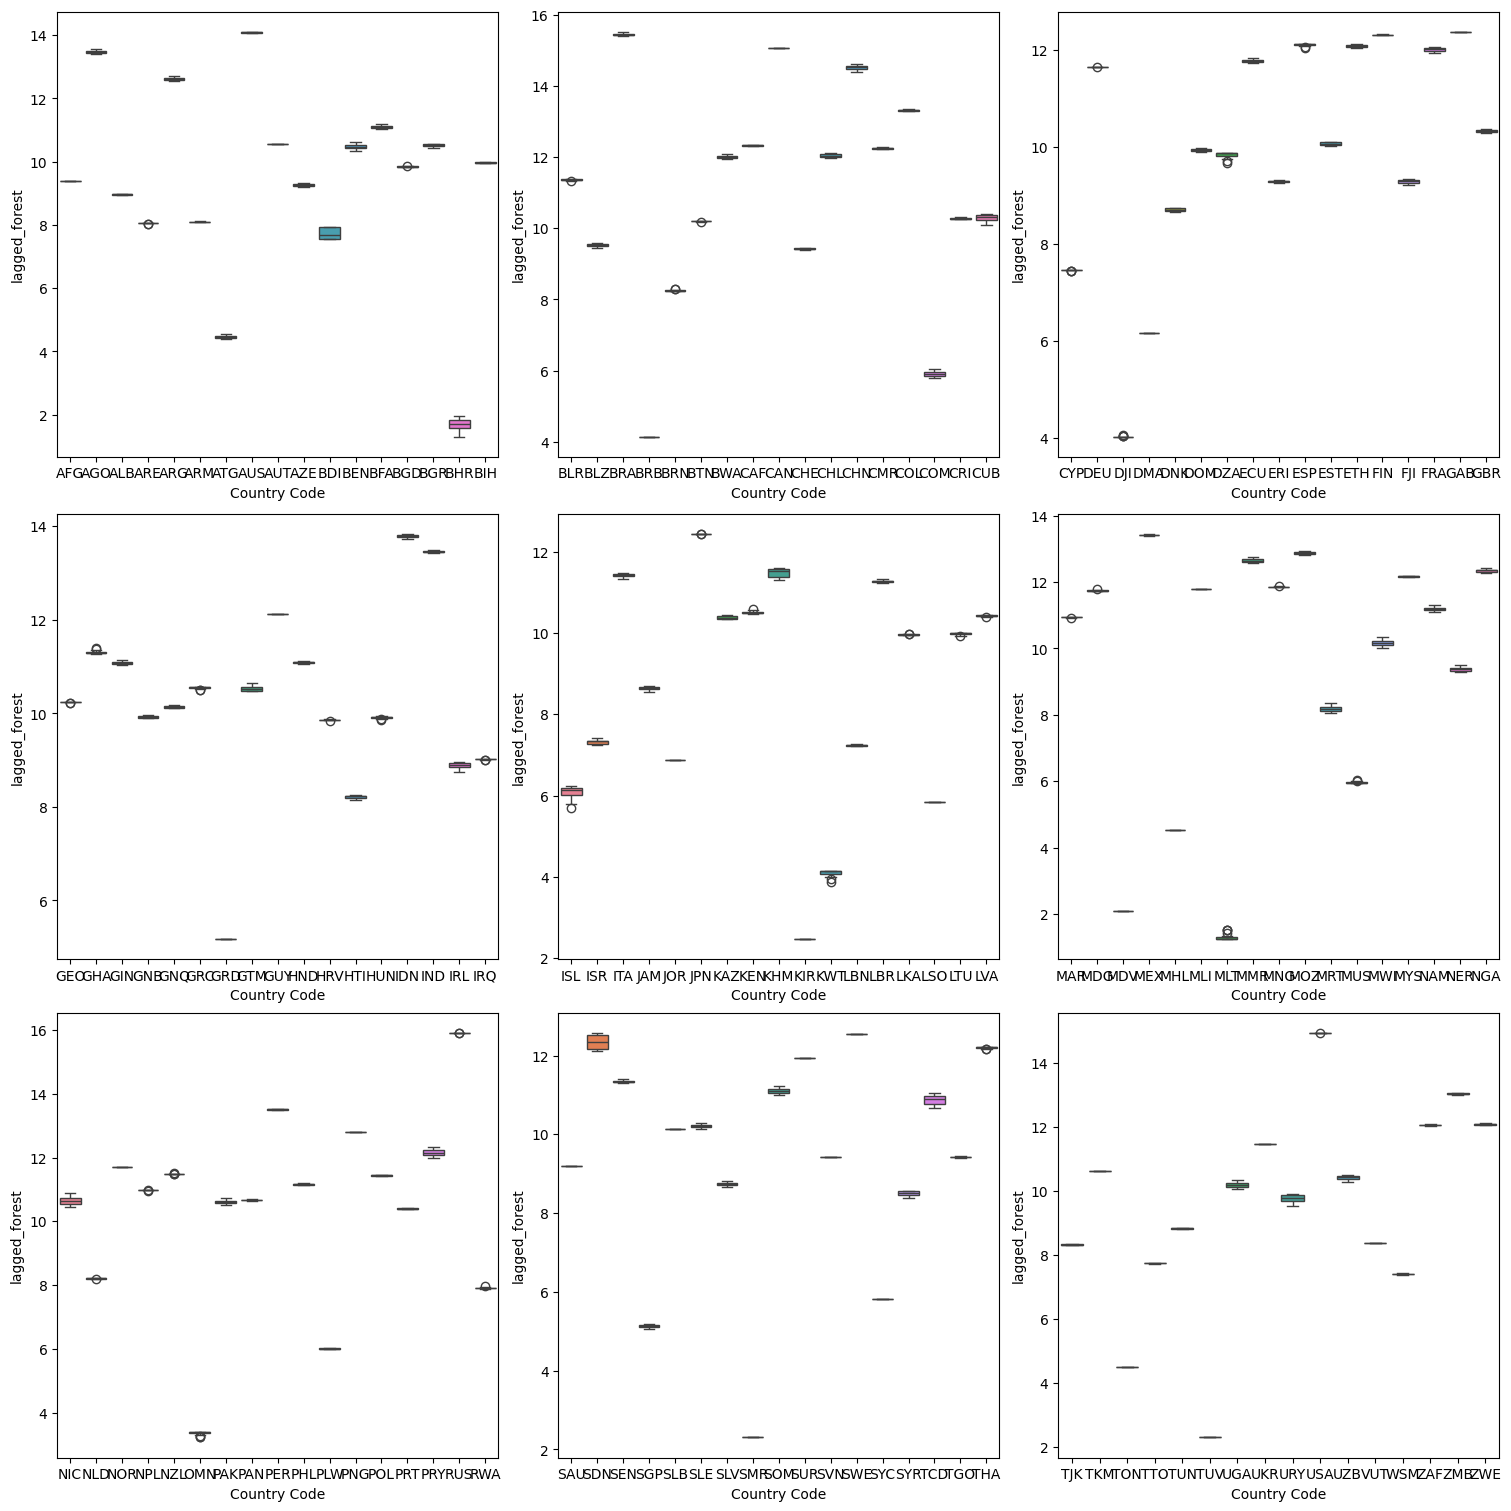

In [14]:
#Dividing by contries
countries = forest['Country Code'].unique()
countries_per_fig = 17
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = forest[forest['Country Code'].isin(group)]
    sns.boxplot(x='Country Code', y='lagged_forest', data= data, hue = 'Country Code', legend=False, ax=ax)
    #ax.set_title(f'Boxplot of GHG values by Country - Group {i + 1}')
    #ax.set_xlabel('Country Code')
    #ax.set_ylabel('GHG Values')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [72]:
# Function to detect outliers using IQR method for a given group
def detect_outliers(group):
    Q1 = group['lagged_forest'].quantile(0.25)
    Q3 = group['lagged_forest'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['lagged_forest'] < lower_bound) | (group['lagged_forest'] > upper_bound)]

# Group by 'Country Code' and apply the outlier detection function
outliers = forest.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)

# Total number of outliers
total_outliers = outliers.shape[0]
print("\nTotal number of outliers:", total_outliers)

# Number of outliers per country
outliers_per_country = outliers.groupby('Country Code').size()
print("\nNumber of outliers per 'Country Code':")
print(outliers_per_country)
print(f'Number of countries with outliers: {len(outliers_per_country)}')
print(f'Number of countries with 2 or more outliers: {(outliers_per_country > 2).sum()}')
print(f'Max number of outliers per country: {max(outliers_per_country)}')


Total number of outliers: 64

Number of outliers per 'Country Code':
Country Code
ARE    2
BGD    1
BLR    1
BRN    2
BTN    1
CYP    3
DEU    1
DJI    4
DZA    2
ESP    2
GEO    2
GHA    2
GRC    2
HRV    1
HUN    2
IRQ    2
ISL    1
JPN    2
KEN    1
KWT    2
LKA    2
LTU    1
LVA    1
MAR    1
MDG    1
MLT    4
MNG    1
MUS    2
NLD    1
NPL    2
NZL    3
OMN    3
RUS    2
RWA    1
THA    2
USA    1
dtype: int64
Number of countries with outliers: 36
Number of countries with 2 or more outliers: 5
Max number of outliers per country: 4


C:\Users\mlj\AppData\Local\Temp\ipykernel_19348\2010724140.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = forest.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)


Maybe consider removing at least DJI as it is constant and MLT is almost constant except for year 2016, and OMN is the same.  . Decided to remove OMN, MLT, DJB, as they just present many outliers and their numbers are exaclty the same during the years, which might indicate wrong values. 

In [73]:
big_outliers = outliers_per_country[(outliers_per_country > 1)]

print(big_outliers)

Country Code
ARE    2
BRN    2
CYP    3
DJI    4
DZA    2
ESP    2
GEO    2
GHA    2
GRC    2
HUN    2
IRQ    2
JPN    2
KWT    2
LKA    2
MLT    4
MUS    2
NPL    2
NZL    3
OMN    3
RUS    2
THA    2
dtype: int64


<Axes: xlabel='Country Code', ylabel='forest_area'>

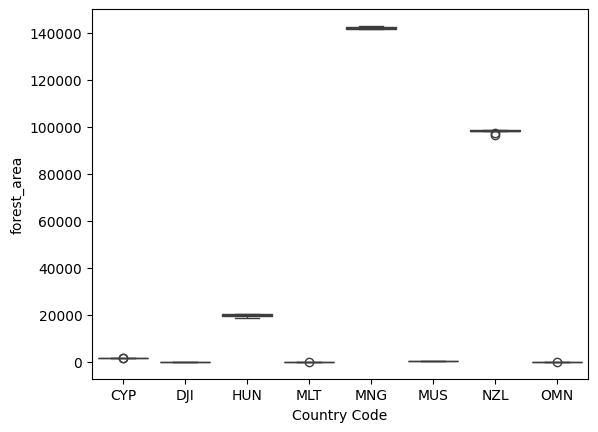

In [6]:
big_outliers = ['CYP', 'DJI','HUN', 'MLT', 'MNG', 'MUS', 'NZL', 'OMN' ]
data = forest[forest['Country Code'].isin(big_outliers)]
sns.boxplot(x='Country Code', y='forest_area', data= data, hue = 'Country Code', legend=False)


<Axes: xlabel='Year', ylabel='forest_area'>

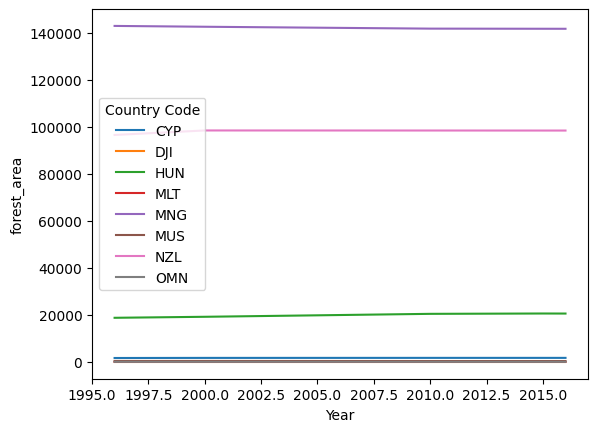

In [14]:

sns.lineplot(x='Year', y='forest_area', data= data, hue = 'Country Code')

In [74]:
#Defining the country to remove
countries_to_remove = ['OMN', 'MLT', 'DJI'] 

#Filtering the DataFrame to remove the specified countries
forest = forest[~forest['Country Code'].isin(countries_to_remove)]

Checking our size rank variable after removing outliers. 

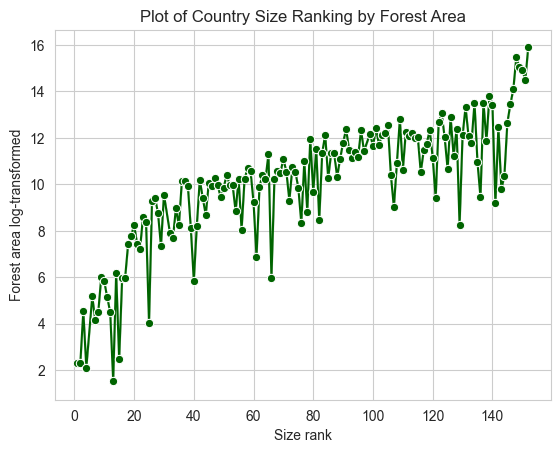

In [125]:

sns.lineplot(x='Size_rank', y='log_forest', data = forest,marker='o', color='darkgreen')
plt.title('Plot of Country Size Ranking by Forest Area')
plt.xlabel('Size rank')
plt.ylabel('Forest area log-transformed')
plt.show()

# Data splitting

In [75]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

Data splitting in training, validation and test sets. (Random state remains the same throughout the notebook, so the splits should also remain the same)

In [76]:
#Defining the features (X) and the target variable (y)
#Removing for x
X = forest.drop(columns=['Country Name', 'forest_area', 'log_forest'])
y = forest['lagged_forest'] 

#Defining the group variable (Country)
groups = forest['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42) 
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]


In [77]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1872, 14) (1872,)
Validation set shape: (414, 14) (414,)
Test set shape: (396, 14) (396,)


Checking training data for representative sample. 

In [24]:
#Plotting the size rank for each split 

val = X_val['Size_rank']
test = X_test['Size_rank']
train = X_train['Size_rank']

size_df = pd.DataFrame({
    'val': val,
    'test': test,
    'train': train
})


size_df = pd.melt(size_df)
display(size_df)


,variable,value
0,val,NaN
1,val,NaN
2,val,NaN
3,val,NaN
4,val,NaN
...,...,...
8041,train,103.0
8042,train,103.0
8043,train,103.0
8044,train,103.0


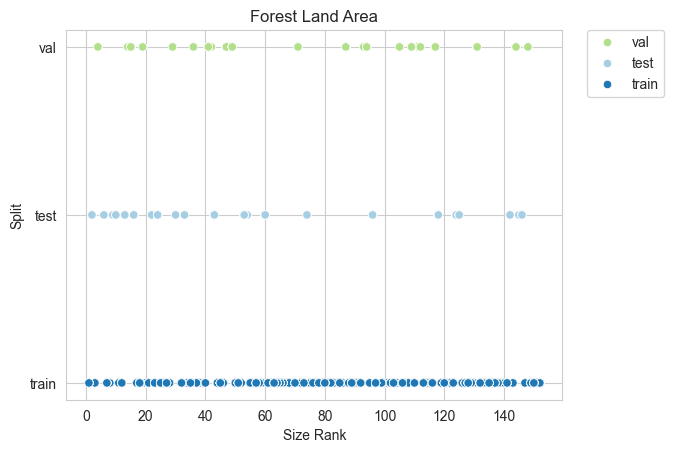

In [99]:
sns.scatterplot(data=size_df, 
                y='variable', 
                x='value', 
                marker='o', 
                hue='variable', palette=my_palette)
plt.title('Forest Land Area')
plt.ylabel('Split')
plt.xlabel('Size Rank')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Data modelling 

In [78]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pickle as pkl

In [93]:
performances = []

## Baseline median model

This portion calculates the mean log-transformed forest area from X_train to be fit on the other splits.

In [94]:
# Calculate median lagged_forest for X_train
median_lagged_forest_train = X_train['lagged_forest'].median()

# Function to add median values to a dataset
def add_median_values(df, median_value):
    df['median_prediction'] = median_value
    return df

# List of datasets to process
datasets = [(X_train, 'X_train'), (X_val, 'X_val'), (X_test, 'X_test')]

# Iterate over the datasets and add the median values
for x, name in datasets:
    x = add_median_values(x, median_lagged_forest_train)


C:\Users\mlj\AppData\Local\Temp\ipykernel_19348\2357007286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['median_prediction'] = median_value


In [95]:
sorted_X_val = X_val.sort_values(by='Country Code')
display(sorted_X_val)


,Country Code,Year,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest,Size_rank,median_prediction
198,BEN,1996.0,6203860.0,112760.0,0.259205,1.050372,-0.380564,-0.176318,0.052316,-0.548115,-3.407600,0.642331,10.629864,71,10.47025
215,BEN,2016.0,11260085.0,112760.0,0.408386,-0.008784,-0.624919,-0.583056,-0.625831,-0.529120,26.760221,0.690871,10.353017,71,10.47025
214,BEN,2015.0,10932783.0,112760.0,0.294566,-0.020496,-0.681488,-0.621767,-0.554906,-0.563475,29.226725,0.717781,10.368840,71,10.47025
213,BEN,2014.0,10614844.0,112760.0,0.264593,0.027140,-0.484983,-0.620842,-0.485179,-0.669144,27.953034,0.718178,10.384416,71,10.47025
212,BEN,2013.0,10308730.0,112760.0,0.155496,0.301189,-0.508523,-0.415550,-0.567833,-0.745443,31.783311,0.700578,10.399753,71,10.47025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,UKR,1998.0,50144500.0,579350.0,-0.240637,-0.120934,-0.848181,-0.707293,-0.982280,-1.258210,23.730931,0.336553,11.463483,117,10.47025
2574,UKR,1996.0,51057800.0,579350.0,-0.324850,-0.152149,-0.670080,-0.418922,-0.823547,-1.110137,18.501924,0.336541,11.462684,117,10.47025
2590,UKR,2015.0,45154036.0,579290.0,-0.086787,-1.959532,-0.553356,-0.618873,-0.872506,-1.038948,58.319669,0.300588,11.480815,117,10.47025
2581,UKR,2006.0,46787786.0,579360.0,0.049641,-0.036878,-0.523428,-0.486631,-0.821370,-0.772782,44.328739,0.331618,11.466672,117,10.47025


Fitting the model

In [96]:
model = 'Baseline Median Model'

# Evaluate the model on train, validation, and test sets
for x, y, nsplit, name in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    
    
    # Calculate performance metrics for the baseline model on the current data split
    mae = mean_absolute_error(y, x['median_prediction'])
    mse = mean_squared_error(y, x['median_prediction'])  # Calculate MSE
    rmse = np.sqrt(mse)  # Calculate RMSE
    mape = mean_absolute_percentage_error(y, x['median_prediction'])
    r2 = r2_score(y, x['median_prediction'])

    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

## Simple linear model with demographic predictors

In [97]:
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Simple Demographic'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Compare the two baseline models

In [98]:
perf_df = pd.DataFrame(performances)

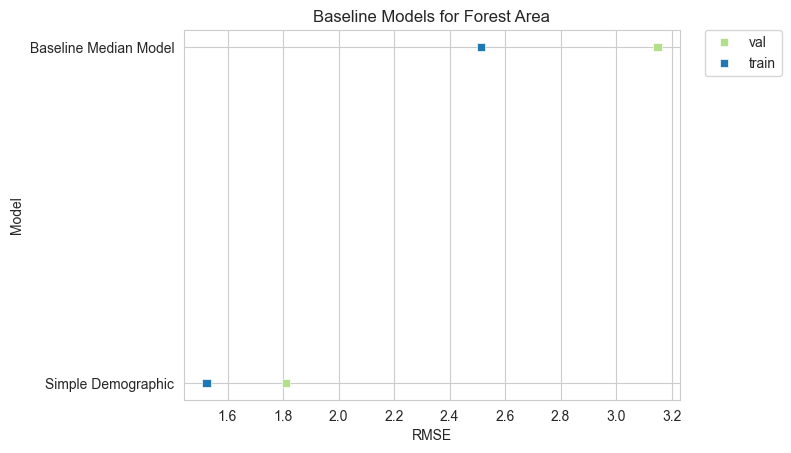

In [99]:
val_df = perf_df[perf_df['split'] != 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=val_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.title('Baseline Models for Forest Area')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Linear Models Overview

**Social Predictors (Voice & Accountability, Health):**
- Adds `WGI VA` and `Health` to demographic predictors.
- Fits and evaluates the linear model, stores, and visualizes performance metrics.

**Full Social Model (Including ICT):**
- Adds `ICT` to the social predictors.
- Fits and evaluates the model, stores, and visualizes performance metrics.

**Governance Predictors (Regulatory Quality, Government Effectiveness, Rule of Law):**
- Adds `WGI RQ`, `WGI GE`, and `WGI RL` to demographic predictors.
- Fits and evaluates the model, stores, and visualizes performance metrics.

**Full Governance Model (Including Political Stability, Control of Corruption):**
- Adds `WGI PS` and `WGI CC` to the governance predictors.
- Fits and evaluates the model, stores, and visualizes performance metrics.

## Linear models with social predictors 


### Theory driven, voice and accaountability and health

In [100]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Social Theory'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Full social model including ICT 

In [101]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]

soc_full = LinearRegression().fit(X_train_selected, y_train)

model = 'Social Full'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]
    preds = soc_full.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

## Linear models with governance predictors 

### Theory driven: regulatory quality, government effectiveness, and rule of law

In [102]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]

gov_theory = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Theory'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]
    preds = gov_theory.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Full model including political stability and control of corruption 

In [103]:
#Now let's fit a linear model with only dempographic variable 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl', 'WGI_ps', 'WGI_cc']]

reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Full'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl', 'WGI_ps', 'WGI_cc']]
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

## Comparison of linear models

In [198]:
perf_df = pd.DataFrame(performances)

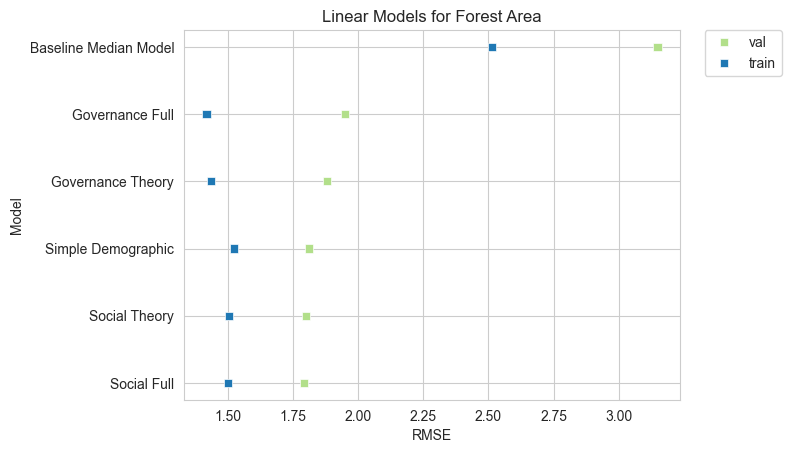

In [199]:
val_df = perf_df[perf_df['split'] != 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=val_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Linear Models for Forest Area')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()

In [128]:
display(val_df)

,model,split,rmse
0,Baseline Median Model,train,2.5136
1,Baseline Median Model,val,3.1486
2,Simple Demographic,train,1.5240
3,Simple Demographic,val,1.8110
4,Social Theory,train,1.5050
5,Social Theory,val,1.8000
6,Social Full,train,1.4991
7,Social Full,val,1.7913
8,Governance Theory,train,1.4354
9,Governance Theory,val,1.8811


It looks like the social full model is doing a bit better on the validation than the others with a RMSE of 1.7913. But there is not a clear difference between any except the baseline median model. The best governance model is the governance theory model with RMSE of 1.8811, but that is doing slightly worse than the simple demographic with RMSE of 1.8110. 

## Assessing our linear regressions

Here we check that there are not obvious trends of the validation predictions in our social full model and our governance theory model. 

#### Social full model 

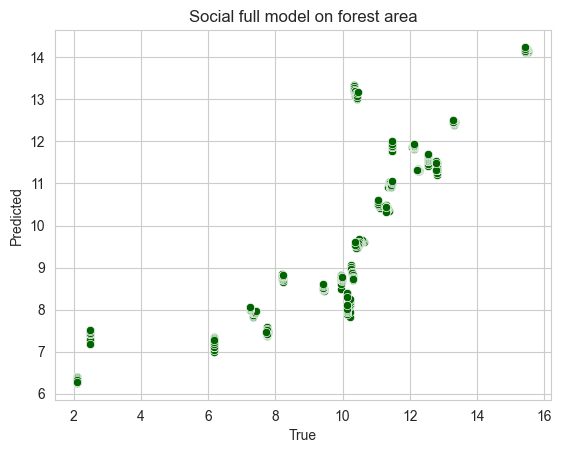

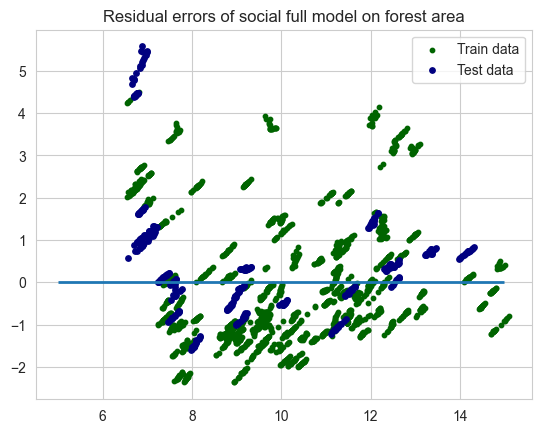

In [142]:
#Social full model 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]
X_test_selected =X_test[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]
soc_val = LinearRegression().fit(X_train_selected, y_train)

X_val_selected = X_val[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]
soc_preds = soc_val.predict(X_val_selected)
absolute_error = np.abs(soc_preds - y_val)

sns.scatterplot(x=y_val, y=soc_preds, color = 'Darkgreen')
plt.title('Social full model on forest area')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

# plotting residual errors in training data 
plt.scatter(soc_val.predict(X_train_selected), 
            soc_val.predict(X_train_selected) - y_train, 
            color="darkgreen", s=10, 
            label='Train data') 
  
# plotting residual errors in test data 
plt.scatter(soc_val.predict(X_test_selected), 
            soc_val.predict(X_test_selected) - y_test, 
            color="navy", s=15, 
            label='Test data') 

plt.hlines(y=0, xmin=5, xmax=15, linewidth=2) 
plt.legend(loc='upper right') 
plt.title("Residual errors of social full model on forest area") 
plt.show() 

#### Governance theory model

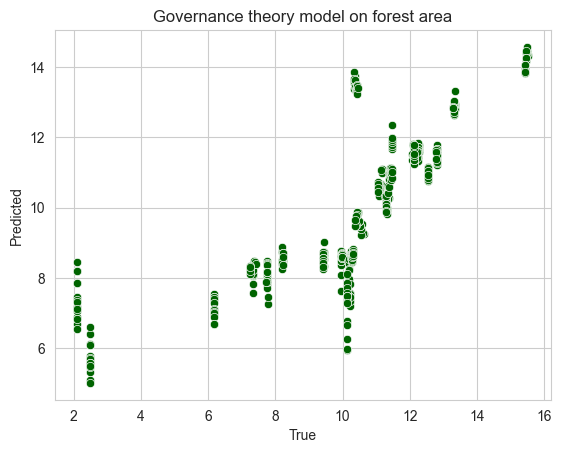

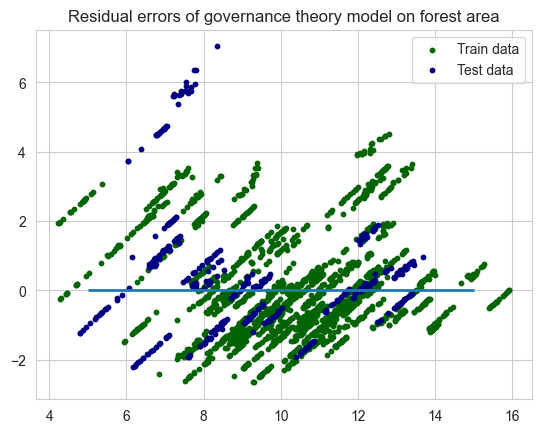

In [143]:
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]
X_test_selected =X_test[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]
gov_val = LinearRegression().fit(X_train_selected, y_train)

X_val_selected = X_val[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]
gov_preds = gov_val.predict(X_val_selected)
absolute_error = np.abs(gov_preds - y_val)

sns.scatterplot(x=y_val, y=gov_preds, color = 'Darkgreen')
plt.title('Governance theory model on forest area')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

# plotting residual errors in training data 
plt.scatter(gov_val.predict(X_train_selected), 
            gov_val.predict(X_train_selected) - y_train, 
            color="darkgreen", s=10, 
            label='Train data') 
  
# plotting residual errors in test data 
plt.scatter(gov_val.predict(X_test_selected), 
            gov_val.predict(X_test_selected) - y_test, 
            color="navy", s=10, 
            label='Test data') 

plt.hlines(y=0, xmin=5, xmax=15, linewidth=2) 
plt.legend(loc='upper right') 
plt.title("Residual errors of governance theory model on forest area") 
plt.show() 

## Mixed Effects Linear Regressor (MERF)

- **Data Preparation**
  - Split datasets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`
  - Define random effects matrix `Z` using the 'Year' feature
  - Select features for training excluding the target and random effects columns
  - Assign clusters using 'Country Code'

- **Model Training**
  - Instantiate `MERF()` model
  - Fit the model with `X_train_selected`, `Z_train`, `clusters_train`, `y_train`

- **Performance Evaluation**
  - Evaluate on train, validation, and test sets
  - Metrics: RMSE, MAE, MAPE, R2
  - Store and print performance metrics for each dataset split

- **Performance Visualization**
  - Create scatter plots to visualize RMSE, MAE, MAPE, R2 for different splits using `sns.scatterplot`

- **SHAP Analysis**
  - Calculate SHAP values for the fixed effects model
  - Plot SHAP summary plot

- **Model Variants**
  - **Government Readiness Model**: Excludes 'Country Code', 'WGI VA', 'ICT', 'Health'
  - **Social Readiness Model**: Excludes 'Country Code', 'WGI PS', 'WGI GE', 'WGI RQ', 'WGI RL', 'WGI CC'

In [27]:

from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import shap

c:\Users\mlj\OneDrive - Aarhus Universitet\MA 2. Semester\Data Science\DataScienceExam\data_sci_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
display(X_train)

,Country Code,Year,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest,Size_rank,median_prediction
0,AFG,1996.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,9.399671,121,10.47025
1,AFG,1998.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,9.399671,121,10.47025
2,AFG,2000.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,9.399671,121,10.47025
3,AFG,2002.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,9.399671,121,10.47025
4,AFG,2003.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,9.399671,121,10.47025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ZWE,2012.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,12.079878,103,10.47025
2732,ZWE,2013.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,12.077261,103,10.47025
2733,ZWE,2014.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,12.074637,103,10.47025
2734,ZWE,2015.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,12.072007,103,10.47025


### Combined MERF Model

In [105]:
model = 'MERF Full'

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'lagged_forest', 'Size_rank', 'median_prediction'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'lagged_forest', 'Size_rank', 'median_prediction'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': rmse.round(4)
        })

INFO     [merf.py:307] Training GLL is -7042.323822708121 at iteration 1.
INFO     [merf.py:307] Training GLL is -10667.957120718367 at iteration 2.
INFO     [merf.py:307] Training GLL is -10931.647294638975 at iteration 3.
INFO     [merf.py:307] Training GLL is -11312.489697917325 at iteration 4.
INFO     [merf.py:307] Training GLL is -11650.351661989225 at iteration 5.
INFO     [merf.py:307] Training GLL is -11450.399557582674 at iteration 6.
INFO     [merf.py:307] Training GLL is -11664.29729354862 at iteration 7.
INFO     [merf.py:307] Training GLL is -11824.240306579111 at iteration 8.
INFO     [merf.py:307] Training GLL is -11984.562088379478 at iteration 9.
INFO     [merf.py:307] Training GLL is -12181.75445361357 at iteration 10.
INFO     [merf.py:307] Training GLL is -12149.152648357831 at iteration 11.
INFO     [merf.py:307] Training GLL is -12365.870671143402 at iteration 12.
INFO     [merf.py:307] Training GLL is -12479.537104421805 at iteration 13.
INFO     [merf.py:307] T

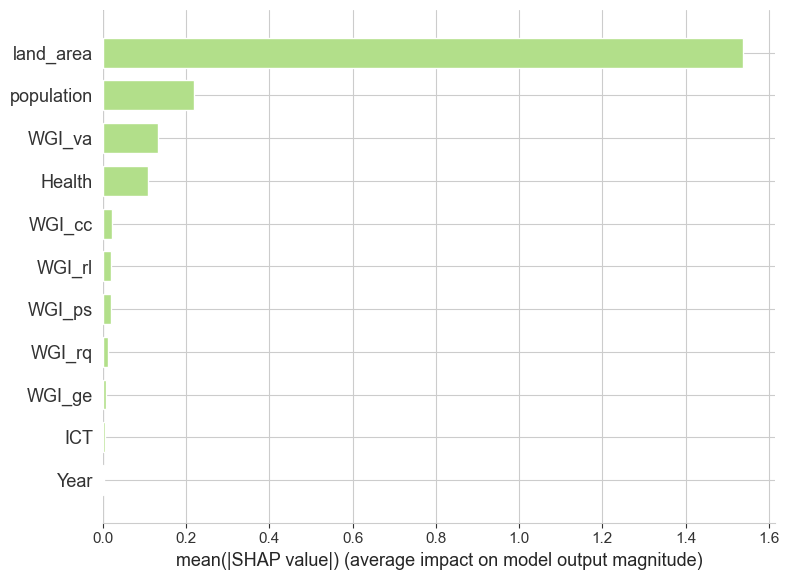

In [29]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar", color=sns.color_palette('Paired')[2])

### Governmental Readiness MERF Model

In [104]:
# Define the model name
model = "Governance MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'lagged_forest', 'Size_rank', 'median_prediction', 'WGI_va', 'ICT', 'Health'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'lagged_forest', 'Size_rank', 'median_prediction', 'WGI_va', 'ICT', 'Health'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': rmse.round(4)
        })

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7074.144951096142 at iteration 1.
INFO     [merf.py:307] Training GLL is -10691.935959459532 at iteration 2.
INFO     [merf.py:307] Training GLL is -11138.265354196543 at iteration 3.
INFO     [merf.py:307] Training GLL is -11433.942631485816 at iteration 4.
INFO     [merf.py:307] Training GLL is -11465.167514044037 at iteration 5.
INFO     [merf.py:307] Training GLL is -11768.679268508804 at iteration 6.
INFO     [merf.py:307] Training GLL is -11806.553189337988 at iteration 7.
INFO     [merf.py:307] Training GLL is -12144.120873459126 at iteration 8.
INFO     [merf.py:307] Training GLL is -12125.367491639616 at iteration 9.
INFO     [merf.py:307] Training GLL is -12168.363638959505 at iteration 10.
INFO     [merf.py:307] Training GLL is -12356.37373138669 at iteration 11.
INFO     [merf.py:307] Training GLL is -12640.2060777121 at iteration 12.
INFO     [merf.py:307] Training GLL is -12930.326883298807 at iteration 13.
INFO     [merf.py:307] Tr

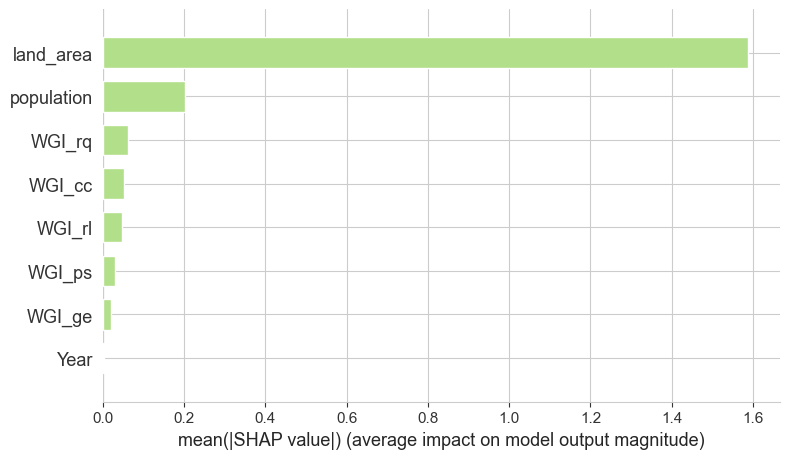

In [31]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar", color=sns.color_palette('Paired')[2])

### Social Readiness MERF Model

In [106]:
# Define the model name
model = "Social MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'median_prediction', 'lagged_forest', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc', 'Size_rank'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'median_prediction', 'lagged_forest', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc', 'Size_rank'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': rmse.round(4)
        })

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7110.859608410804 at iteration 1.
INFO     [merf.py:307] Training GLL is -11059.175407700584 at iteration 2.
INFO     [merf.py:307] Training GLL is -11613.277025520112 at iteration 3.
INFO     [merf.py:307] Training GLL is -11764.862628284758 at iteration 4.
INFO     [merf.py:307] Training GLL is -11940.824354603983 at iteration 5.
INFO     [merf.py:307] Training GLL is -11936.637638637252 at iteration 6.
INFO     [merf.py:307] Training GLL is -12002.191108682382 at iteration 7.
INFO     [merf.py:307] Training GLL is -12017.939675856005 at iteration 8.
INFO     [merf.py:307] Training GLL is -12146.262015291371 at iteration 9.
INFO     [merf.py:307] Training GLL is -12495.55262700381 at iteration 10.
INFO     [merf.py:307] Training GLL is -12383.322610942318 at iteration 11.
INFO     [merf.py:307] Training GLL is -12362.732281621136 at iteration 12.
INFO     [merf.py:307] Training GLL is -12388.58680308477 at iteration 13.
INFO     [merf.py:307] T

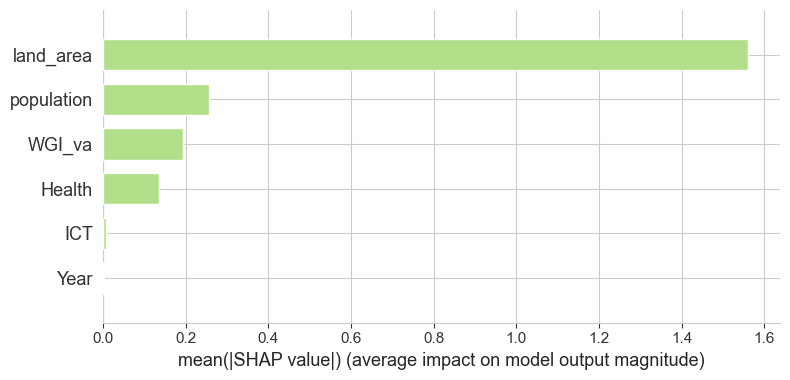

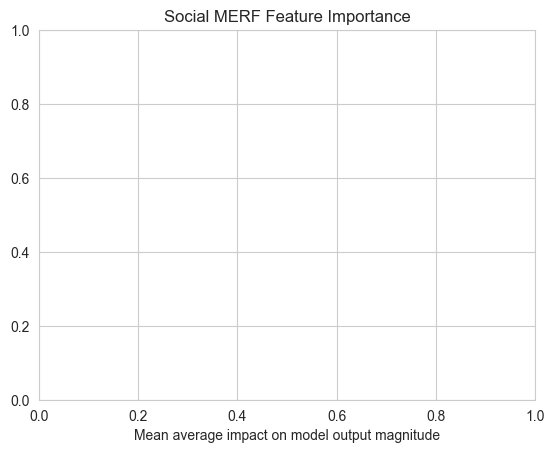

In [91]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar", color=sns.color_palette('Paired')[2])


## Comparison of linear and MERF models 

In [34]:
perf_df = pd.DataFrame(performances)

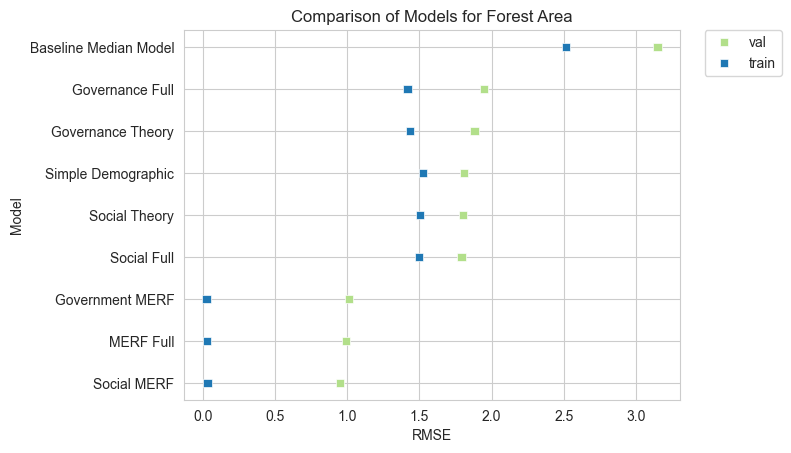

In [35]:
val_df = perf_df[perf_df['split'] != 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=val_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models for Forest Area')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()


In [150]:
display(val_df)

,model,split,rmse
0,Baseline Median Model,train,2.5136
1,Baseline Median Model,val,3.1486
2,Simple Demographic,train,1.5240
3,Simple Demographic,val,1.8110
4,Social Theory,train,1.5050
5,Social Theory,val,1.8000
6,Social Full,train,1.4991
7,Social Full,val,1.7913
8,Governance Theory,train,1.4354
9,Governance Theory,val,1.8811


# Ridge and Lasso CV
We see that the merf's are doing best, and as there are no methods for tuning the hyperparameters applied for the merf yet, we are gonna try making the linear models better. According to the RMSE, the full social model is doing best of the social models and the governance theory is doing better than the full governance mode, so we will try tuning those ones to see if we can adjust according to our hypothesis. We will apply both lasso and ridge regularization as there are no obvious evidence that some features are completely irrelevant (which would mean that we would use Lasso/L1). So we will try both.

In [47]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

In [107]:
X_train = X_train.drop(columns=['Country Code'])
X_val = X_val.drop(columns=['Country Code'])
X_test = X_test.drop(columns=['Country Code'])

Our WGI indicators are all standardized, but we standardize population, land_area, and ICT. We want to keep the rest as is, because they are modelling fixed effects such as year and size rank.   

In [108]:
scaler = StandardScaler()
X_train[['population','land_area','ICT']] = scaler.fit_transform(X_train[['population','land_area','ICT']])
X_val[['population','land_area','ICT']] = scaler.transform(X_val[['population','land_area','ICT']])
X_test[['population','land_area','ICT']] = scaler.transform(X_test[['population','land_area','ICT']])

## Social full model regularization

### Ridge regularization CV on full social model 

In [109]:
#Setting alphas to cover a large space
alphas = 10**np.linspace(10,-2,100)*0.5

#Choosing the simple and social predictors 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

ridgecv.fit(X_train_selected, y_train)

ridgecv.alpha_

3.0679536367065814

In [110]:
#Fitting the ridge model with the estimated best alpha on our full social linear model
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]

ridge_high = Ridge(ridgecv.alpha_)
ridge_reg = ridge_high.fit(X_train_selected, y_train)

model = 'Social Full Ridge CV Alpha'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]
    preds = ridge_reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Lasso regularization on full social model

In [111]:
#Choosing the simple and social predictors 
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]

lassocv = LassoCV(alphas = alphas)

lassocv.fit(X_train_selected, y_train)

lassocv.alpha_ 

0.08148754173103201

In [112]:

X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]

lasso = Lasso(lassocv.alpha_)
lasso_reg = lasso.fit(X_train_selected, y_train)


model = 'Social Full Lasso CV Alpha'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_va', 'Health', 'ICT']]
    preds = lasso_reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Plotting and comparing

In [50]:
perf_df = pd.DataFrame(performances)

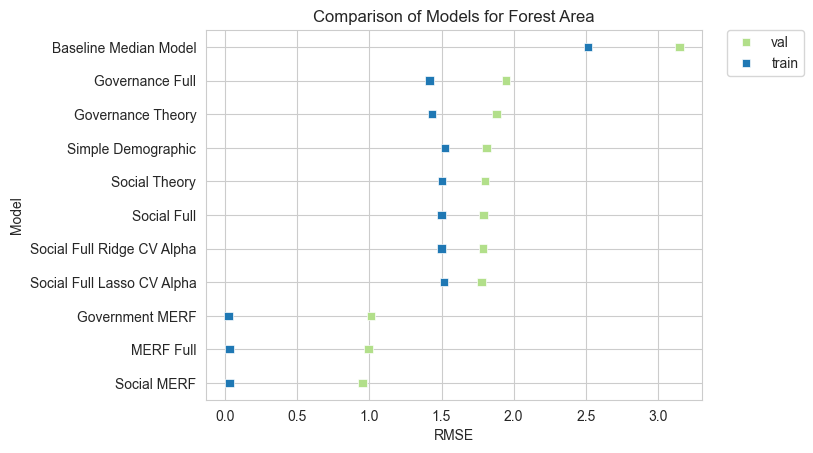

In [51]:
val_df = perf_df[perf_df['split'] != 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=val_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models for Forest Area')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()

In [53]:
display(val_df)

,model,split,rmse
0,Baseline Median Model,train,2.5136
1,Baseline Median Model,val,3.1486
2,Simple Demographic,train,1.5240
3,Simple Demographic,val,1.8110
4,Social Theory,train,1.5050
5,Social Theory,val,1.8000
6,Social Full,train,1.4991
7,Social Full,val,1.7913
8,Governance Theory,train,1.4354
9,Governance Theory,val,1.8811


We can see that the model actually does not do much better in either model and that the merf is still way better. Now we check how much the lasso and the ridge reguralized our model. It seems like it didnt do a lot except for shrinking health a bit.

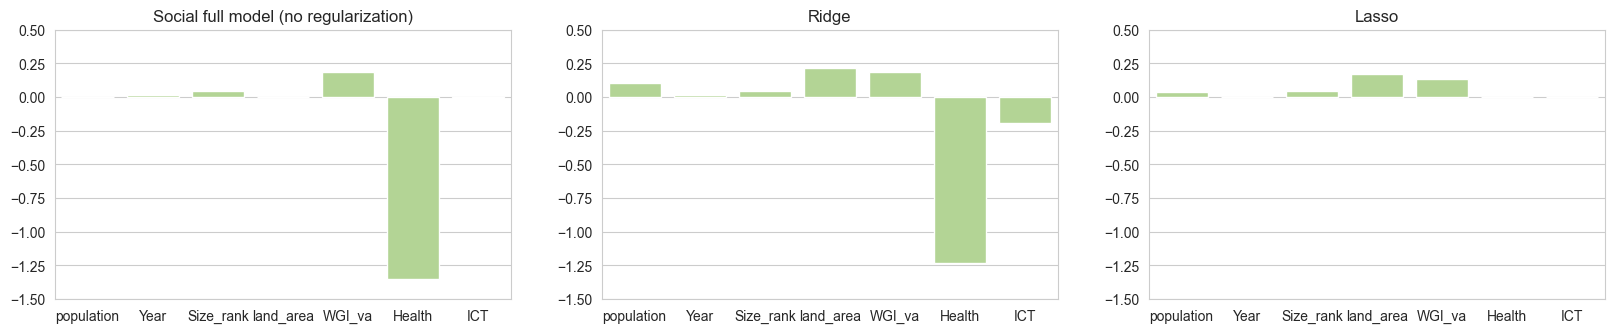

In [52]:
fig, ax = plt.subplots(ncols=3, figsize=(20,3.5))
sns.barplot(x=X_train_selected.columns, y=lasso_reg.coef_, ax=ax[2], color=sns.color_palette('Paired')[2])
sns.barplot(x=X_train_selected.columns, y=ridge_reg.coef_, ax=ax[1], color=sns.color_palette('Paired')[2])
sns.barplot(x=X_train_selected.columns, y=soc_full.coef_, ax=ax[0], color=sns.color_palette('Paired')[2])
for a in ax:
    a.set_ylim(-1.5,0.5)
ax[2].set_title('Lasso')
ax[1].set_title('Ridge')
ax[0].set_title('Social full model (no regularization)')
ax[2].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xlabel('')
plt.show()

## Governance theory model reguralization 

In [113]:
#Setting alphas to cover a large space
alphas = 10**np.linspace(10,-2,100)*0.5

### Ridge

In [114]:
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]

ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')

ridgecv.fit(X_train_selected, y_train)

ridgecv.alpha_

1.7555958671075638

In [115]:

X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]

ridge_high = Ridge(ridgecv.alpha_)
ridge_reg = ridge_high.fit(X_train_selected, y_train)

#reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Full Ridge CV Alpha'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]
    preds = ridge_reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Lasso

In [116]:
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]

lassocv = LassoCV(alphas = alphas)

lassocv.fit(X_train_selected, y_train)

lassocv.alpha_ 

0.06164233697210317

In [117]:
#Fitting the ridge model with the estimated best alpha on our full social linear model
X_train_selected = X_train[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]

lasso = Lasso(lassocv.alpha_)
lasso_reg = lasso.fit(X_train_selected, y_train)

#reg = LinearRegression().fit(X_train_selected, y_train)

model = 'Governance Full Lasso CV Alpha'

for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # select predictors
    x_selected = x[['population', 'Year', 'Size_rank','land_area', 'WGI_rq', 'WGI_ge', 'WGI_rl']]
    preds = lasso_reg.predict(x_selected)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    
    # Append performance metrics to the list
    performances.append({
        'model': model,
        'split': nsplit,
        'rmse': round(rmse, 4)
    })

### Plotting and comparing

In [59]:
perf_df = pd.DataFrame(performances)


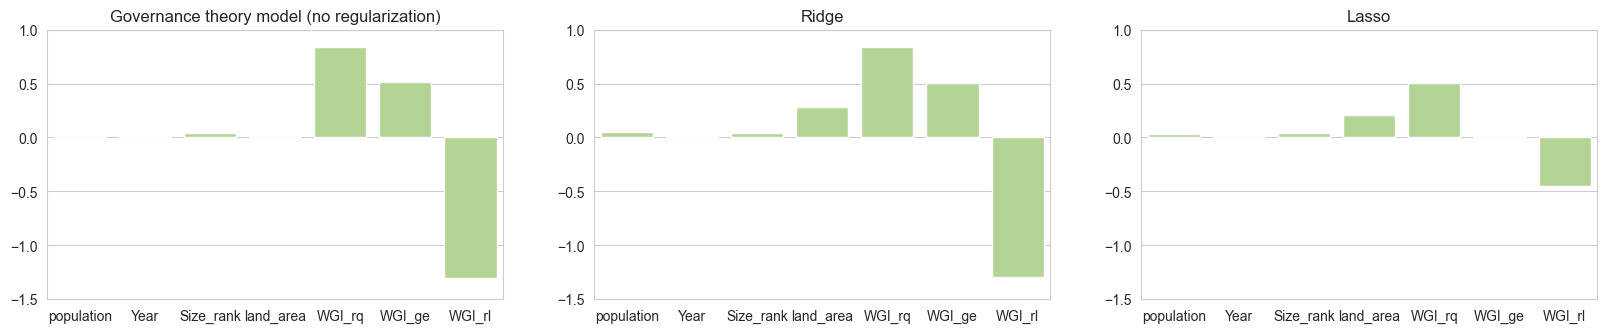

In [60]:

fig, ax = plt.subplots(ncols=3, figsize=(20,3.5))
sns.barplot(x=X_train_selected.columns, y=lasso_reg.coef_, ax=ax[2], color=sns.color_palette('Paired')[2])
sns.barplot(x=X_train_selected.columns, y=ridge_reg.coef_, ax=ax[1], color=sns.color_palette('Paired')[2])
sns.barplot(x=X_train_selected.columns, y=gov_theory.coef_, ax=ax[0], color=sns.color_palette('Paired')[2])
for a in ax:
    a.set_ylim(-1.5,1)
ax[2].set_title('Lasso')
ax[1].set_title('Ridge')
ax[0].set_title('Governance theory model (no regularization)')
ax[2].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_xlabel('')
plt.show()

## Plotting all models

In [119]:
perf_df = pd.DataFrame(performances)

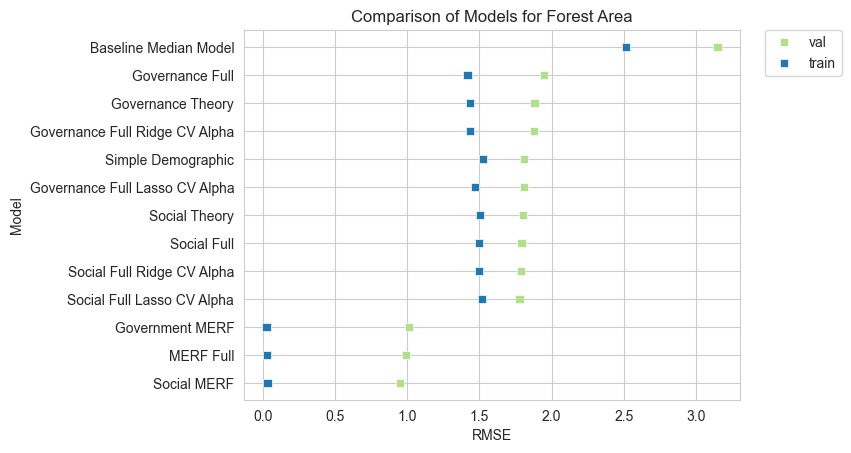

In [62]:
val_df = perf_df[perf_df['split'] != 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=val_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models for Forest Area')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()


# Compare and evaluate all models on test

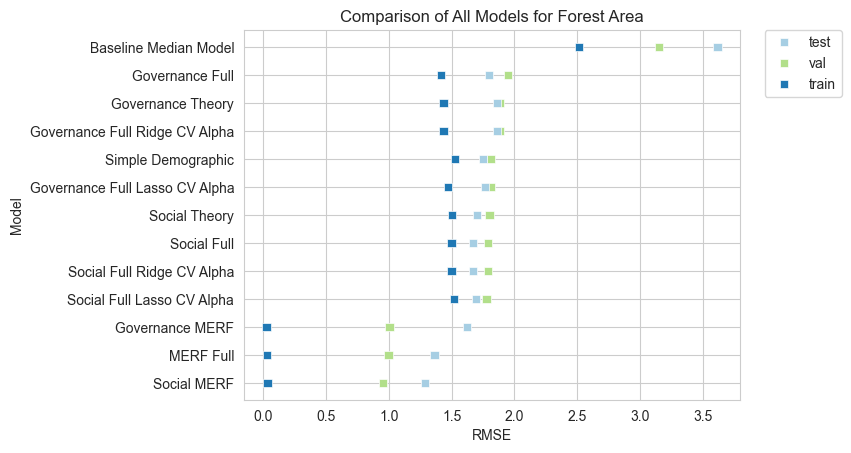

In [120]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of All Models for Forest Area')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()


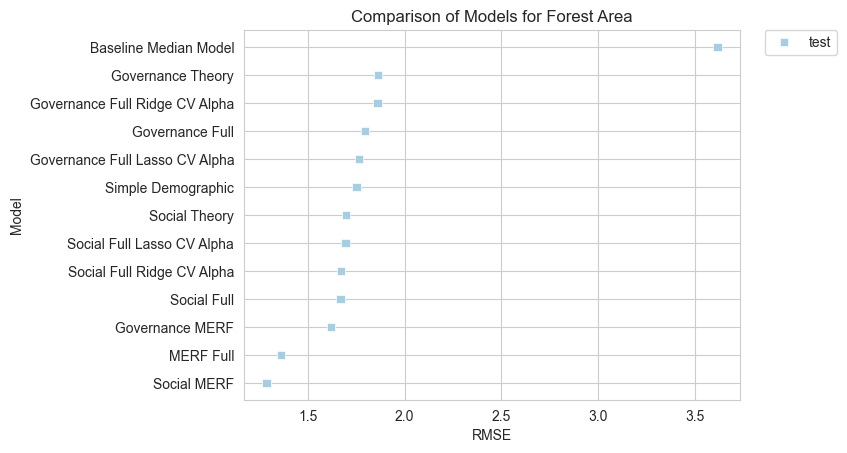

In [121]:
test_df = perf_df[perf_df['split'] == 'test'].reset_index(drop=True)
sns.set_style('whitegrid')
sns.scatterplot(data=test_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=my_palette)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Models for Forest Area')
plt.ylabel('Model')
plt.xlabel('RMSE')
plt.show()


In [122]:
display(test_df)

,model,split,rmse
0,Baseline Median Model,test,3.6155
1,Simple Demographic,test,1.7513
2,Social Theory,test,1.6990
3,Social Full,test,1.6688
4,Governance Theory,test,1.8620
5,Governance Full,test,1.7966
6,Governance MERF,test,1.6211
7,MERF Full,test,1.3627
8,Social MERF,test,1.2866
9,Social Full Ridge CV Alpha,test,1.6713


In [124]:
display(test_df)

,model,split,rmse
0,Baseline Median Model,test,3.6155
1,Simple Demographic,test,1.7513
2,Social Theory,test,1.6990
3,Social Full,test,1.6688
4,Governance Theory,test,1.8620
5,Governance Full,test,1.7966
6,Governance MERF,test,1.6211
7,MERF Full,test,1.3627
8,Social MERF,test,1.2866
9,Social Full Ridge CV Alpha,test,1.6713
